# Plant Background Removal

In [3]:
import spectral
import matplotlib.pyplot as plt
import numpy as np

## For RGB-D Images

In [4]:
header_file = r'/media/sasank-v/New Volume/Studies/College/Interships/APPN - ANU/3d_hyperspec_ai/data/csiro_fx10_17_2_wheat/004-specim-fx10.hdr'
image = spectral.open_image(header_file)
wavelengths = image.metadata["wavelength"]
print(len(wavelengths))
print(wavelengths)

224
['397.66', '400.28', '402.9', '405.52', '408.13', '410.75', '413.37', '416', '418.62', '421.24', '423.86', '426.49', '429.12', '431.74', '434.37', '437', '439.63', '442.26', '444.89', '447.52', '450.16', '452.79', '455.43', '458.06', '460.7', '463.34', '465.98', '468.62', '471.26', '473.9', '476.54', '479.18', '481.83', '484.47', '487.12', '489.77', '492.42', '495.07', '497.72', '500.37', '503.02', '505.67', '508.32', '510.98', '513.63', '516.29', '518.95', '521.61', '524.27', '526.93', '529.59', '532.25', '534.91', '537.57', '540.24', '542.91', '545.57', '548.24', '550.91', '553.58', '556.25', '558.92', '561.59', '564.26', '566.94', '569.61', '572.29', '574.96', '577.64', '580.32', '583', '585.68', '588.36', '591.04', '593.73', '596.41', '599.1', '601.78', '604.47', '607.16', '609.85', '612.53', '615.23', '617.92', '620.61', '623.3', '626', '628.69', '631.39', '634.08', '636.78', '639.48', '642.18', '644.88', '647.58', '650.29', '652.99', '655.69', '658.4', '661.1', '663.81', '666

In [5]:
image = image.load()
image.shape

(2127, 1024, 224)

### Finding Normalized Difference Vegetation Index (NDVI)

In [6]:
wavelengths = np.array(wavelengths, dtype=float)

# Define wavelength ranges (nm)
red_min, red_max = 665.0, 680.0
nir_min, nir_max = 750.0, 800.0

# Find indices
red_indices = np.where((wavelengths >= red_min) & (wavelengths <= red_max))[0]
nir_indices = np.where((wavelengths >= nir_min) & (wavelengths <= nir_max))[0]

red_start, red_end = red_indices[0], red_indices[-1]
nir_start, nir_end = nir_indices[0], nir_indices[-1]

In [7]:
red_reflectance = image[:,:,red_start:red_end+1].mean(axis=2)
nir_reflectance = image[:,:,nir_start:nir_end+1].mean(axis=2)
print(red_reflectance.shape)
print(nir_reflectance.shape)

(2127, 1024)
(2127, 1024)


In [8]:
NDVI = (nir_reflectance - red_reflectance)/(nir_reflectance + red_reflectance)
NDVI.shape

(2127, 1024)

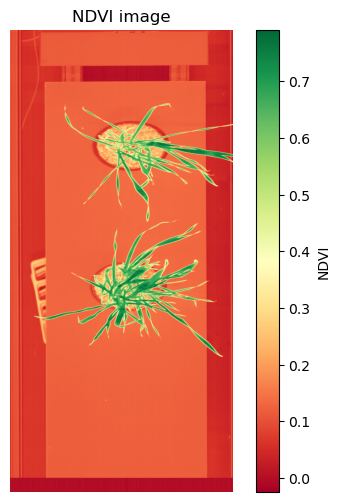

In [9]:
plt.figure(figsize=(6, 6))
plt.imshow(NDVI, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title('NDVI image')
plt.axis('off')
plt.show()

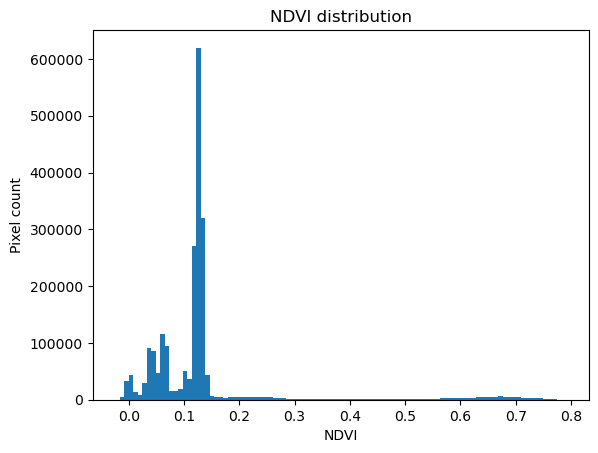

In [10]:
ndvi_flat = NDVI.flatten()
plt.figure()
plt.hist(ndvi_flat, bins=100)
plt.xlabel('NDVI')
plt.ylabel('Pixel count')
plt.title('NDVI distribution')
plt.savefig("NDVI Distribution")
plt.show()

### Finding NDVI Threshold

In [11]:
def show_mask(thresh):
    mask = NDVI > thresh
    plt.imshow(mask, cmap='gray')
    plt.title(f"NDVI > {thresh:.2f}")
    plt.axis('off')
    plt.show()

#### 1. Otsu Thresholding

Otsu NDVI threshold: 0.35599536


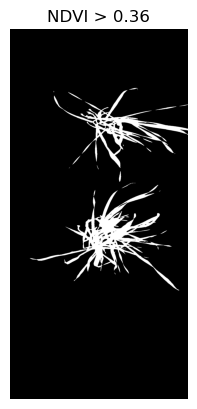

In [12]:
from skimage.filters import threshold_otsu
ndvi_flat = NDVI[np.isfinite(NDVI)]  # remove NaNs / infs
otsu_thresh = threshold_otsu(ndvi_flat)
print("Otsu NDVI threshold:", otsu_thresh)
show_mask(otsu_thresh)

#### 2. Percentile Based Threshold

93th percentile NDVI threshold: 0.26865026


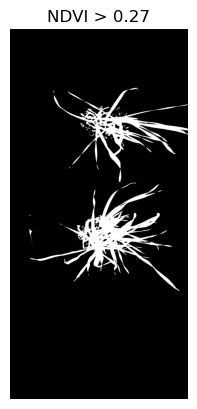

In [13]:
percentile = 93 # try 85, 90, 95
perc_thresh = np.percentile(ndvi_flat, percentile)
print(f"{percentile}th percentile NDVI threshold:", perc_thresh)
show_mask(perc_thresh)   

#### 3. Guassian Mixture Thresholding

GMM NDVI threshold: 0.24714275


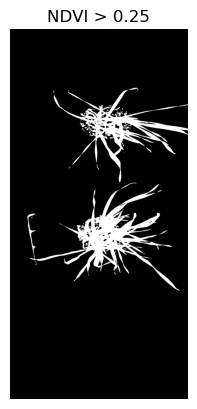

In [14]:
from sklearn.mixture import GaussianMixture

X = ndvi_flat.reshape(-1, 1)

gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(X)

means = gmm.means_.flatten()
covs = gmm.covariances_.flatten()

# Identify vegetation component (higher mean)
veg_comp = np.argmax(means)

# Compute intersection point approximately
xs = np.linspace(ndvi_flat.min(), ndvi_flat.max(), 1000)
probs = gmm.predict_proba(xs.reshape(-1, 1))

# threshold where veg prob exceeds background
gmm_thresh = xs[np.argmax(probs[:, veg_comp] > 0.5)]

print("GMM NDVI threshold:", gmm_thresh)
show_mask(gmm_thresh)

#### 4. Elbow Detection Threshold

Elbow NDVI threshold: 0.15528172


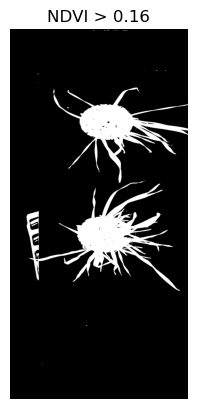

In [15]:
import numpy as np
from scipy.signal import savgol_filter

hist, bins = np.histogram(ndvi_flat, bins=256, density=True)
centers = (bins[:-1] + bins[1:]) / 2

# Smooth histogram
hist_smooth = savgol_filter(hist, 21, 3)

# Second derivative (curvature)
curvature = np.gradient(np.gradient(hist_smooth))

# Elbow = maximum curvature magnitude after main peak
peak_idx = np.argmax(hist_smooth)
elbow_idx = peak_idx + np.argmax(np.abs(curvature[peak_idx:]))

elbow_thresh = centers[elbow_idx]
print("Elbow NDVI threshold:", elbow_thresh)
show_mask(elbow_thresh)

#### 5. Maximum entropy thresholding

Yen entropy threshold: 0.14890987


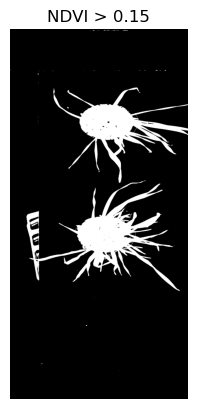

In [16]:
from skimage.filters import threshold_yen

yen_thresh = threshold_yen(ndvi_flat)
print("Yen entropy threshold:", yen_thresh)
show_mask(yen_thresh)

#### 6. MAD-based robust thresholding

MAD NDVI threshold: 0.15556271


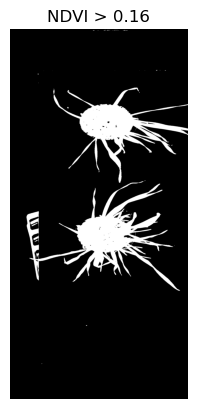

In [17]:
median = np.median(ndvi_flat)
mad = np.median(np.abs(ndvi_flat - median))

k = 3  # sensitivity
mad_thresh = median + k * mad

print("MAD NDVI threshold:", mad_thresh)
show_mask(mad_thresh)

#### 7. Spatial-consistency aware  thresholding

Spatial NDVI threshold: 0.3345224


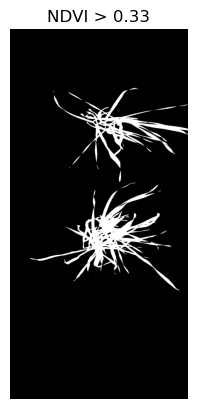

In [18]:
from scipy.ndimage import gaussian_filter

ndvi_smooth = gaussian_filter(NDVI, sigma=2)
spatial_thresh = threshold_otsu(ndvi_smooth[np.isfinite(ndvi_smooth)])

print("Spatial NDVI threshold:", spatial_thresh)
show_mask(spatial_thresh)

#### 8. Meta Method

Consensus NDVI threshold: 0.24714275


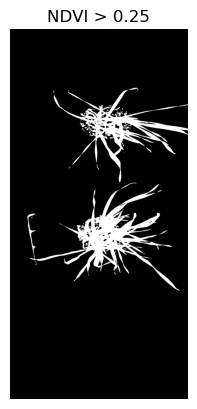

In [19]:
thresholds = np.array([
    otsu_thresh,
    perc_thresh,
    gmm_thresh,
    yen_thresh,
    elbow_thresh,
    mad_thresh,
    spatial_thresh,
])

final_thresh = np.median(thresholds)
print("Consensus NDVI threshold:", final_thresh)
show_mask(final_thresh)

### Apply the Mask over the original image

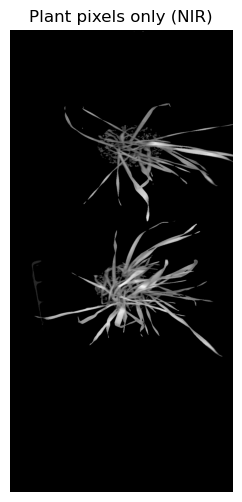

In [20]:
plant_mask = NDVI > final_thresh
plant_only = nir_reflectance.copy()
plant_only[~plant_mask] = 0
plt.figure(figsize=(6, 6))
plt.imshow(plant_only, cmap='gray')
plt.title('Plant pixels only (NIR)')
plt.axis('off')
plt.show()

## For SWIR ( Short-Wave Infrared ) Images

In [25]:
header_file = r'/media/sasank-v/New Volume/Studies/College/Interships/APPN - ANU/3d_hyperspec_ai/data/csiro_fx10_17_2_wheat/004-specim-fx17.hdr'
image = spectral.open_image(header_file)
wavelengths = image.metadata["wavelength"]
print(len(wavelengths))
print(wavelengths)

224
['935.61', '939.06', '942.52', '945.98', '949.43', '952.89', '956.35', '959.81', '963.27', '966.73', '970.19', '973.65', '977.11', '980.58', '984.04', '987.51', '990.97', '994.43', '997.90', '1001.37', '1004.83', '1008.30', '1011.77', '1015.24', '1018.71', '1022.18', '1025.65', '1029.12', '1032.59', '1036.06', '1039.53', '1043.00', '1046.48', '1049.95', '1053.43', '1056.90', '1060.38', '1063.85', '1067.33', '1070.81', '1074.29', '1077.76', '1081.24', '1084.72', '1088.20', '1091.68', '1095.17', '1098.65', '1102.13', '1105.61', '1109.10', '1112.58', '1116.07', '1119.55', '1123.04', '1126.52', '1130.01', '1133.50', '1136.99', '1140.47', '1143.96', '1147.45', '1150.94', '1154.43', '1157.93', '1161.42', '1164.91', '1168.40', '1171.90', '1175.39', '1178.89', '1182.38', '1185.88', '1189.37', '1192.87', '1196.37', '1199.87', '1203.37', '1206.87', '1210.37', '1213.87', '1217.37', '1220.87', '1224.37', '1227.87', '1231.38', '1234.88', '1238.39', '1241.89', '1245.40', '1248.90', '1252.41', '1

In [26]:
image = image.load()
image.shape

(2126, 640, 224)

### Using Water Absorbtion Depths

In [110]:
wavelengths = np.array(wavelengths, dtype=float)

r1_min, r1_max = 1080.0, 1150.0
r2_min, r2_max = 1400.0, 1470.0

r1_indices = np.where((wavelengths >= r1_min) & (wavelengths <= r1_max))[0]
r2_indices = np.where((wavelengths >= r2_min) & (wavelengths <= r2_max))[0]

r1_start, r1_end = r1_indices[0], r1_indices[-1]
r2_start, r2_end = r2_indices[0], r2_indices[-1]

In [111]:
r1_reflectance = image[:,:,r1_start:r1_end+1].mean(axis=2)
r2_reflectance = image[:,:,r2_start:r2_end+1].mean(axis=2)
print(r1_reflectance.shape)
print(r2_reflectance.shape)

(2126, 640)
(2126, 640)


#### Normalized Water Absorbtion Contrast Index ( NWACI )

In [112]:
NWACI = (r1_reflectance - r2_reflectance)/(r1_reflectance + r2_reflectance)
NWACI.shape

(2126, 640)

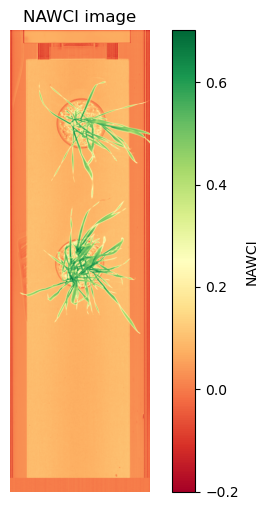

In [118]:
plt.figure(figsize=(6, 6))
plt.imshow(NWACI, cmap='RdYlGn')
plt.colorbar(label='NAWCI')
plt.title('NAWCI image')
plt.axis('off')
plt.show()

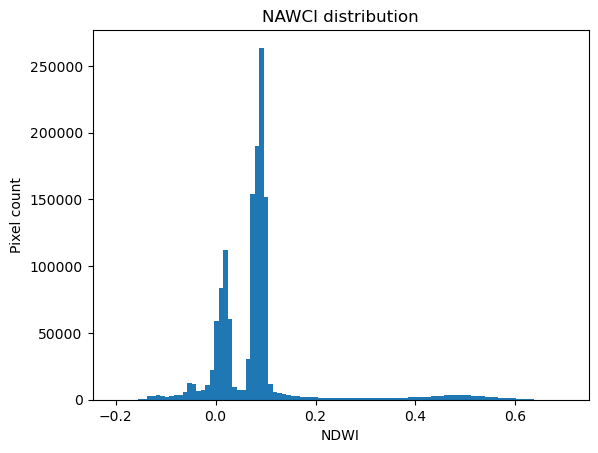

In [119]:
nwaci_flat = NWACI.flatten()
plt.figure()
plt.hist(nwaci_flat, bins=100)
plt.xlabel('NDWI')
plt.ylabel('Pixel count')
plt.title('NAWCI distribution')
plt.savefig("NAWCI Distribution")
plt.show()

In [120]:
def show_mask(thresh):
    mask = NWACI > thresh
    plt.imshow(mask, cmap='gray')
    plt.title(f"NAWCI > {thresh:.2f}")
    plt.axis('off')
    plt.savefig("SWIR Masked Image")
    plt.show()

Otsu NAWCI threshold: 0.2553566


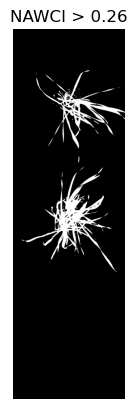

In [121]:
from skimage.filters import threshold_otsu
nwaci_flat = NWACI[np.isfinite(NWACI)]  # remove NaNs / infs
otsu_thresh = threshold_otsu(nwaci_flat)
print("Otsu NAWCI threshold:", otsu_thresh)
show_mask(otsu_thresh)

- We can apply all those thresholding here too 

### Apply mask over the original image

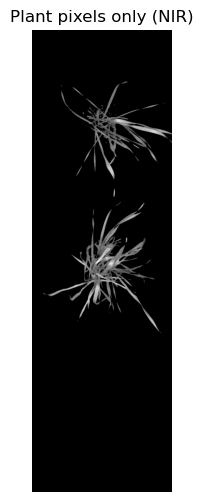

In [122]:
plant_mask = NWACI > otsu_thresh
plant_only = r1_reflectance.copy()
plant_only[~plant_mask] = 0
plt.figure(figsize=(6, 6))
plt.imshow(plant_only, cmap='gray')
plt.title('Plant pixels only (NIR)')
plt.axis('off')
plt.show()